In [1]:
import os
import sys

sys.path.append('../')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import gridspec
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

from kwave.ktransducer import kWaveGrid
from models.ADMM import ADMM_Batched
from models.APACT import APACT
from models.DAS import DAS, DAS_dual
from models.PACT import PSF_PACT, TF_PACT
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.reconstruction import *
from utils.simulations import get_water_SoS
from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'
results_path = '../results/'

### Load in Sinogram

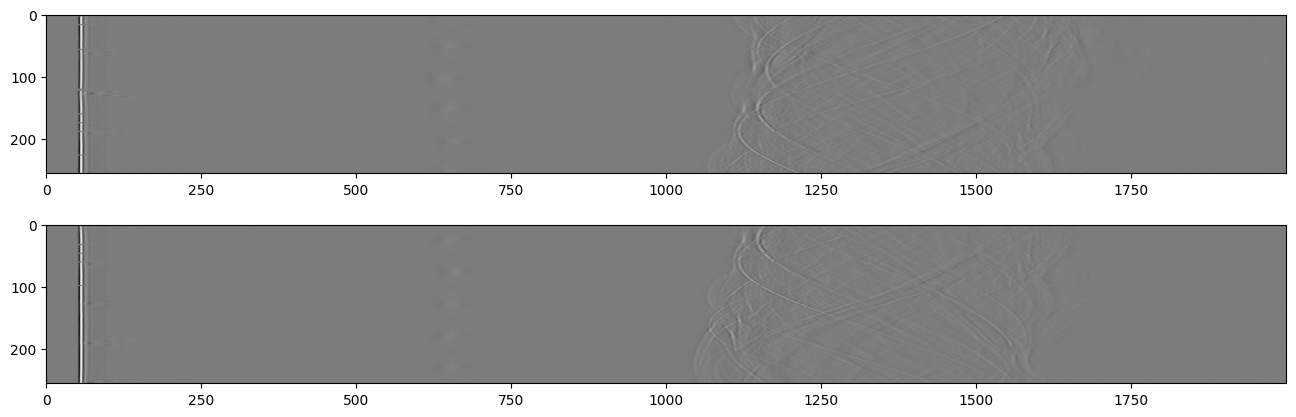

In [2]:
sinogram = load_mat(os.path.join(data_path, 'ANIMAL_LAYER.mat'))
sinogram1 = sinogram[128:128+256,:]
sinogram2 = sinogram[256:,:]
plt.figure(figsize=(16,5))
plt.subplot(2,1,1)
plt.imshow(sinogram1, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(sinogram2, cmap='gray')
plt.show()

### Load and Deconvolve EIR

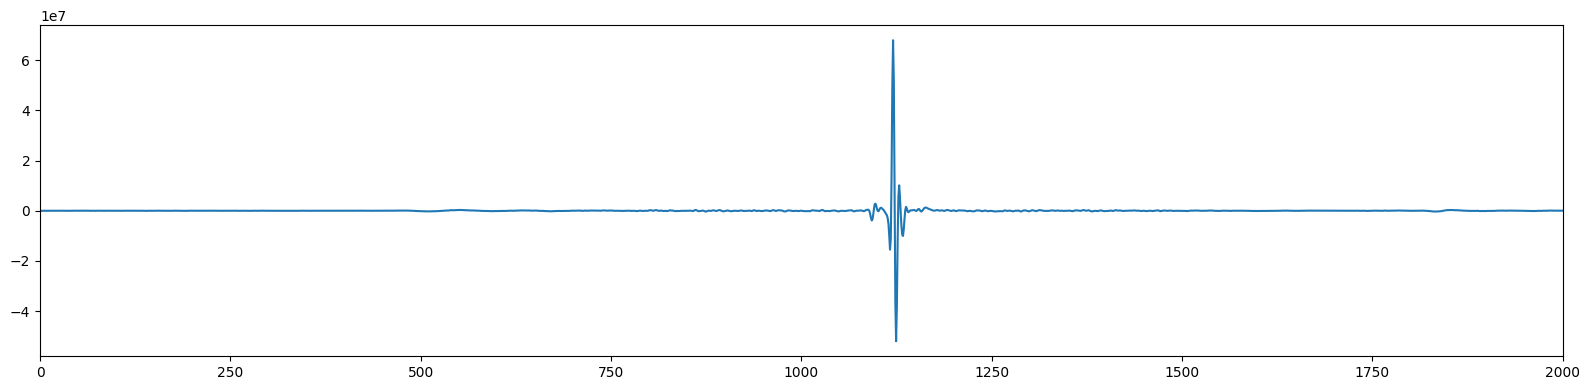

In [3]:
EIR = load_mat(os.path.join(data_path, 'EIR_TUNGSTEN.mat'))

time = np.linspace(0, 2000, 2000)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR[:2000]))
plt.xlim(0, 2000)
plt.tight_layout()

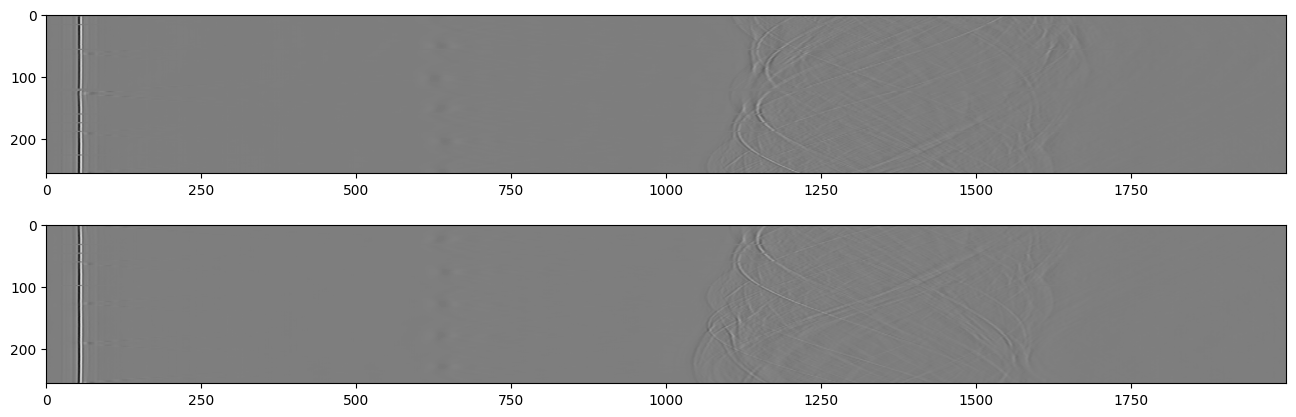

In [4]:
sinogram_deconv1 = deconvolve_sinogram(sinogram1, EIR)
sinogram_deconv2 = deconvolve_sinogram(sinogram2, EIR)

plt.figure(figsize=(16,5))
plt.subplot(2,1,1)
plt.imshow(sinogram_deconv1, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(sinogram_deconv2, cmap='gray')
plt.show()

### Load Ring Error

(256, 1) (256, 1)


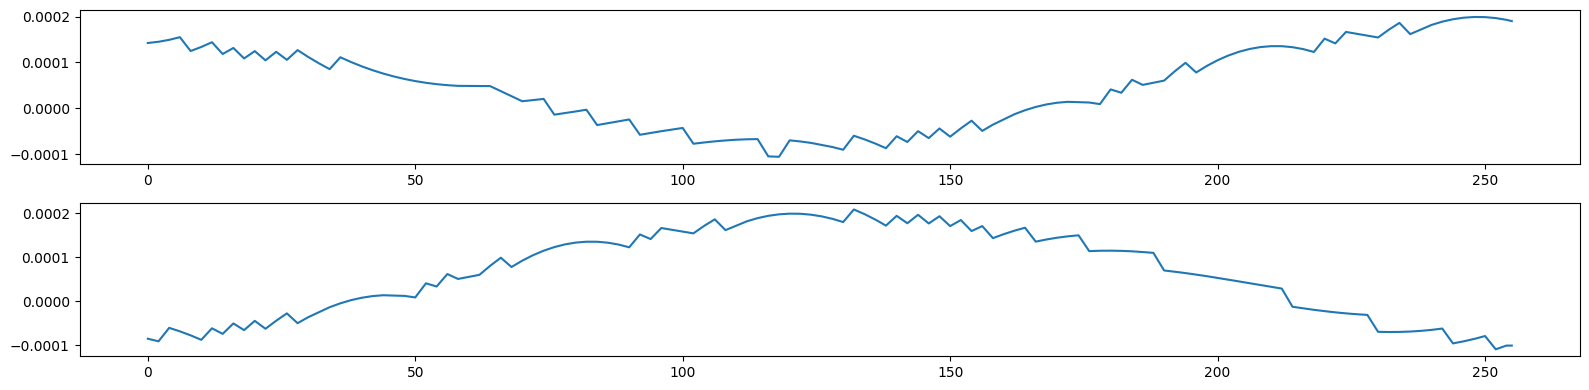

In [5]:
ring_error, transducer_theta = load_mat(os.path.join(data_path, 'RING_ERROR_NEW.mat'))
print(ring_error.shape, transducer_theta.shape)

idx = np.arange(0, 256, 1)
ring_error = np.interp(np.arange(0, 512, 1), np.arange(0, 512, 2), ring_error[:,0]) # Upsample ring error.
ring_error1, ring_error2 = ring_error[128:128+256], ring_error[256:]

plt.figure(figsize=(16,4))
plt.subplot(2,1,1)
plt.plot(idx, ring_error1)
plt.subplot(2,1,2)
plt.plot(idx, ring_error2)
plt.tight_layout()

### Preparations

First, we need to define the size and resolution of the image. We also calculate the X and Y coordinates of each pixels in the image.

In [6]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
x_c, y_c = -26, 15      # Offset of the invivo center w.r.t. the ring array center [pixels].
kgrid = kWaveGrid([Nx+80, Ny+80], [dx, dy])
x_vec, y_vec = kgrid.x_vec[x_c+40:x_c+Nx+40,:], kgrid.y_vec[y_c+40:y_c+Ny+40,:]
l = 3.2e-3              # Patch size [m].

In [7]:
R = 10.6e-3              # Radius of single body [m].
T = 31.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].
v1 = 1554.0             # Avergae SoS in single body [m/s].
print(v0, v1)

1511.4390936112618 1554.0


In [8]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80)).to(device)

In [9]:
das1 = DAS(R_ring=0.05, N_transducer=256, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, angle_range=(0.5*torch.pi, 1.5*torch.pi), mode='zero', device=device)
das1.to(device)
das1.eval()

das2 = DAS(R_ring=0.05, N_transducer=256, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, angle_range=(torch.pi, 2*torch.pi), mode='zero', device=device)
das2.to(device)
das2.eval()

DAS()

### Conventional DAS

In [10]:
with torch.no_grad():
    rec_das1 = das1(sinogram=torch.tensor(sinogram_deconv1[:,46:], device=device), 
                   v0=torch.tensor(1515.0, device=device),
                   d_delay=torch.zeros(1, device=device),
                   ring_error=torch.tensor(ring_error1.reshape(-1,1,1), device=device)).detach().cpu().numpy()
    rec_das2 = das2(sinogram=torch.tensor(sinogram_deconv2[:,46:], device=device), 
                   v0=torch.tensor(1515.0, device=device),
                   d_delay=torch.zeros(1, device=device),
                   ring_error=torch.tensor(ring_error2.reshape(-1,1,1), device=device)).detach().cpu().numpy()

save_mat(os.path.join(results_path, 'das_invivo_half1.mat'), rec_das1.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'das_invivo_half2.mat'), rec_das2.swapaxes(0,1), 'img')

### Dual SoS DAS

In [11]:
das_dual1 = DAS_dual(R_ring=0.05, N_transducer=256, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, angle_range=(0.5*torch.pi, 1.5*torch.pi), R_body=R, center=(x_c*dx, y_c*dy), mode='zero', device=device)
das_dual1.to(device)
das_dual1.eval()

das_dual2 = DAS_dual(R_ring=0.05, N_transducer=256, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, angle_range=(torch.pi, 2*torch.pi), R_body=R, center=(x_c*dx, y_c*dy), mode='zero', device=device)
das_dual2.to(device)
das_dual2.eval()

DAS_dual()

In [12]:
with torch.no_grad():
    rec_das_dual1 = das_dual1(sinogram=torch.tensor(sinogram_deconv1[:,46:], device=device),
                              v0=torch.tensor(v0, device=device),
                              v1=torch.tensor(v1, device=device),
                              d_delay=torch.zeros(1, device=device), 
                              ring_error=torch.tensor(ring_error1.reshape(-1,1,1), device=device)).detach().cpu().numpy()
    rec_das_dual2 = das_dual2(sinogram=torch.tensor(sinogram_deconv2[:,46:], device=device),
                              v0=torch.tensor(v0, device=device),
                              v1=torch.tensor(v1, device=device),
                              d_delay=torch.zeros(1, device=device), 
                              ring_error=torch.tensor(ring_error2.reshape(-1,1,1), device=device)).detach().cpu().numpy()

In [13]:
save_mat(os.path.join(results_path, 'das_dual_invivo_half1.mat'), rec_das_dual1.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'das_dual_invivo_half2.mat'), rec_das_dual2.swapaxes(0,1), 'img')

### APACT

In [14]:
delays_apact = np.arange(-8e-4, 8e-4, 0.5e-4) # Delay distances [m].

apact = APACT(delays=delays_apact, dc_range=[-2e-4, 1.6e-4], amp=3.2e-4, step=4e-5, data_path='./TF_invivo_half/', device=device)
apact.to(device)
apact.eval()

APACT(
  (tf): TF_APACT()
  (loss): MSELoss()
)

In [15]:
img_stack1, img_stack2 = [], []
with torch.no_grad():
    for d_delay in tqdm(delays_apact):
        recon1 = das1(torch.tensor(sinogram_deconv1[:,46:], device=device), 
                     torch.tensor(1515.0, device=device), 
                     torch.tensor(d_delay, device=device), 
                     torch.tensor(ring_error1.reshape(-1,1,1), device=device))
        img_stack1.append(recon1)
        recon2 = das2(torch.tensor(sinogram_deconv2[:,46:], device=device), 
                     torch.tensor(1515.0, device=device), 
                     torch.tensor(d_delay, device=device), 
                     torch.tensor(ring_error2.reshape(-1,1,1), device=device))
        img_stack2.append(recon2)
img_stack1 = torch.stack(img_stack1, dim=0)
img_stack2 = torch.stack(img_stack2, dim=0)

100%|██████████| 32/32 [00:02<00:00, 10.97it/s]


In [16]:
def deconv_full_apact(model, img_stack, gaussian_window):
    rec_apact = torch.zeros_like(img_stack[0], device=device)
    with torch.no_grad():
        for idx in tqdm(range(625)):
            i, j = idx // 25, idx % 25
            obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80] * gaussian_window
            obs = obs.unsqueeze(0).to(device)
            rec, _, _, _ = model(obs)
            rec_apact[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
    return rec_apact.detach().cpu().numpy()

# rec_apact1 = deconv_full_apact(apact, img_stack1, gaussian_window)
rec_apact2 = deconv_full_apact(apact, img_stack2, gaussian_window)

100%|██████████| 625/625 [58:16<00:00,  5.59s/it]


In [17]:
# save_mat(os.path.join(results_path, 'apact_invivo_half1.mat'), rec_apact1.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'apact_invivo_half2.mat'), rec_apact2.swapaxes(0,1), 'img')

### Deconvolution with Single Body PSFs

In [14]:
n_delays = 32
# delays = get_delays(R, v0, v1, n_delays, 'uniform')
delays = np.linspace(-8e-4, 8e-4, n_delays)

img_stack1, img_stack2 = [], []
with torch.no_grad():
    for d_delay in tqdm(delays):
        recon1 = das1(torch.tensor(sinogram_deconv1[:,46:], device=device), 
                      torch.tensor(v0, device=device), 
                      torch.tensor(d_delay, device=device), 
                      torch.tensor(ring_error1.reshape(-1,1,1), device=device))
        img_stack1.append(recon1)
        recon2 = das2(torch.tensor(sinogram_deconv2[:,46:], device=device), 
                      torch.tensor(v0, device=device), 
                      torch.tensor(d_delay, device=device), 
                      torch.tensor(ring_error2.reshape(-1,1,1), device=device))
        img_stack2.append(recon2)
img_stack1 = torch.stack(img_stack1, dim=0)
img_stack2 = torch.stack(img_stack2, dim=0)

100%|██████████| 32/32 [00:02<00:00, 10.95it/s]


In [15]:
psf_pact = PSF_PACT(n_points=160, l=2*l, n_delays=delays.shape[0], device=device)
psf_pact.to(device)
psf_pact.eval()

tf_pact = TF_PACT(n_points=160, l=2*l, n_delays=delays.shape[0], device=device)
tf_pact.to(device)
tf_pact.eval()

TF_PACT()

In [16]:
admm = ADMM_Batched(n_iters=16, lam=0.01, rho=0.08)
wiener = Wiener_Batched(lam=5e-3, order=0.5, device=device)

In [17]:
def deconv_full_sb(model, img_stack, gaussian_window, delays, attention='uniform'):
    model.to(device)
    model.eval()
    img_stack /= img_stack.abs().mean()
    rec_full = torch.zeros_like(img_stack[0], device=device)
    with torch.no_grad():
        for idx in tqdm(range(625)):
            i, j = idx // 25, idx % 25
            x, y = (j-12)*l / 4, (12-i)*l / 4
            r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
            w_real = wavefront_real(R, r, phi, v0, v1)
            # psf = psf_pact(torch.tensor(delays, device=device).view(1,-1,1,1), w_real)
            psf = tf_pact(torch.tensor(delays, device=device).view(1,-1,1,1), w_real)
            obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80]
            _, C0 = get_r_C0(i, j, R, l, v0, v1)
            weights = torch.tensor(get_weights(C0, delays, attention), device=device)
            obs, psf = obs * torch.sqrt(weights), psf * torch.sqrt(weights) # Apply attention weights to different channels.
            obs = obs.unsqueeze(0) * gaussian_window
            rec = model(obs, psf)
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
    return rec_full.detach().cpu().numpy()

rec_wiener1 = deconv_full_sb(wiener, img_stack1, gaussian_window, delays)
rec_wiener2 = deconv_full_sb(wiener, img_stack2, gaussian_window, delays)
rec_wiener_onehot1 = deconv_full_sb(wiener, img_stack1, gaussian_window, delays, 'onehot')
rec_wiener_onehot2 = deconv_full_sb(wiener, img_stack2, gaussian_window, delays, 'onehot')
# rec_admm = deconv_full_sb(admm, img_stack, gaussian_window, delays)

100%|██████████| 625/625 [00:00<00:00, 693.07it/s]


In [18]:
save_mat(os.path.join(results_path, 'sb_wiener_invivo_half1.mat'), rec_wiener1.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'sb_wiener_invivo_half2.mat'), rec_wiener2.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'sb_wiener_onehot_invivo_half1.mat'), rec_wiener_onehot1.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'sb_wiener_onehot_invivo_half2.mat'), rec_wiener_onehot2.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'sb_admm_invivo.mat'), rec_admm.swapaxes(0,1), 'img')

### Visualization

Load and normalize images.

In [19]:
rec_das1 = load_mat(os.path.join(results_path, 'das_invivo_half1.mat'))
rec_das2 = load_mat(os.path.join(results_path, 'das_invivo_half2.mat'))
rec_das_dual1 = load_mat(os.path.join(results_path, 'das_dual_invivo_half1.mat'))
rec_das_dual2 = load_mat(os.path.join(results_path, 'das_dual_invivo_half2.mat'))
rec_apact1 = load_mat(os.path.join(results_path, 'apact_invivo_half1.mat'))
rec_apact2 = load_mat(os.path.join(results_path, 'apact_invivo_half2.mat'))
rec_wiener1 = load_mat(os.path.join(results_path, 'sb_wiener_invivo_half1.mat'))
rec_wiener2 = load_mat(os.path.join(results_path, 'sb_wiener_invivo_half2.mat'))  
rec_wiener_onehot1 = load_mat(os.path.join(results_path, 'sb_wiener_onehot_invivo_half1.mat'))
rec_wiener_onehot2 = load_mat(os.path.join(results_path, 'sb_wiener_onehot_invivo_half2.mat'))
# rec_admm = load_mat(os.path.join(results_path, 'sb_admm_invivo.mat'))

In [20]:
[rec_das1, rec_das2, rec_das_dual1, rec_das_dual2, rec_apact1, rec_apact2, \
 rec_wiener1, rec_wiener2, rec_wiener_onehot1, rec_wiener_onehot2] = \
    [standardize(img) for img in [rec_das1, rec_das2, rec_das_dual1, rec_das_dual2, rec_apact1, rec_apact2, \
                                  rec_wiener1, rec_wiener2, rec_wiener_onehot1, rec_wiener_onehot2]]

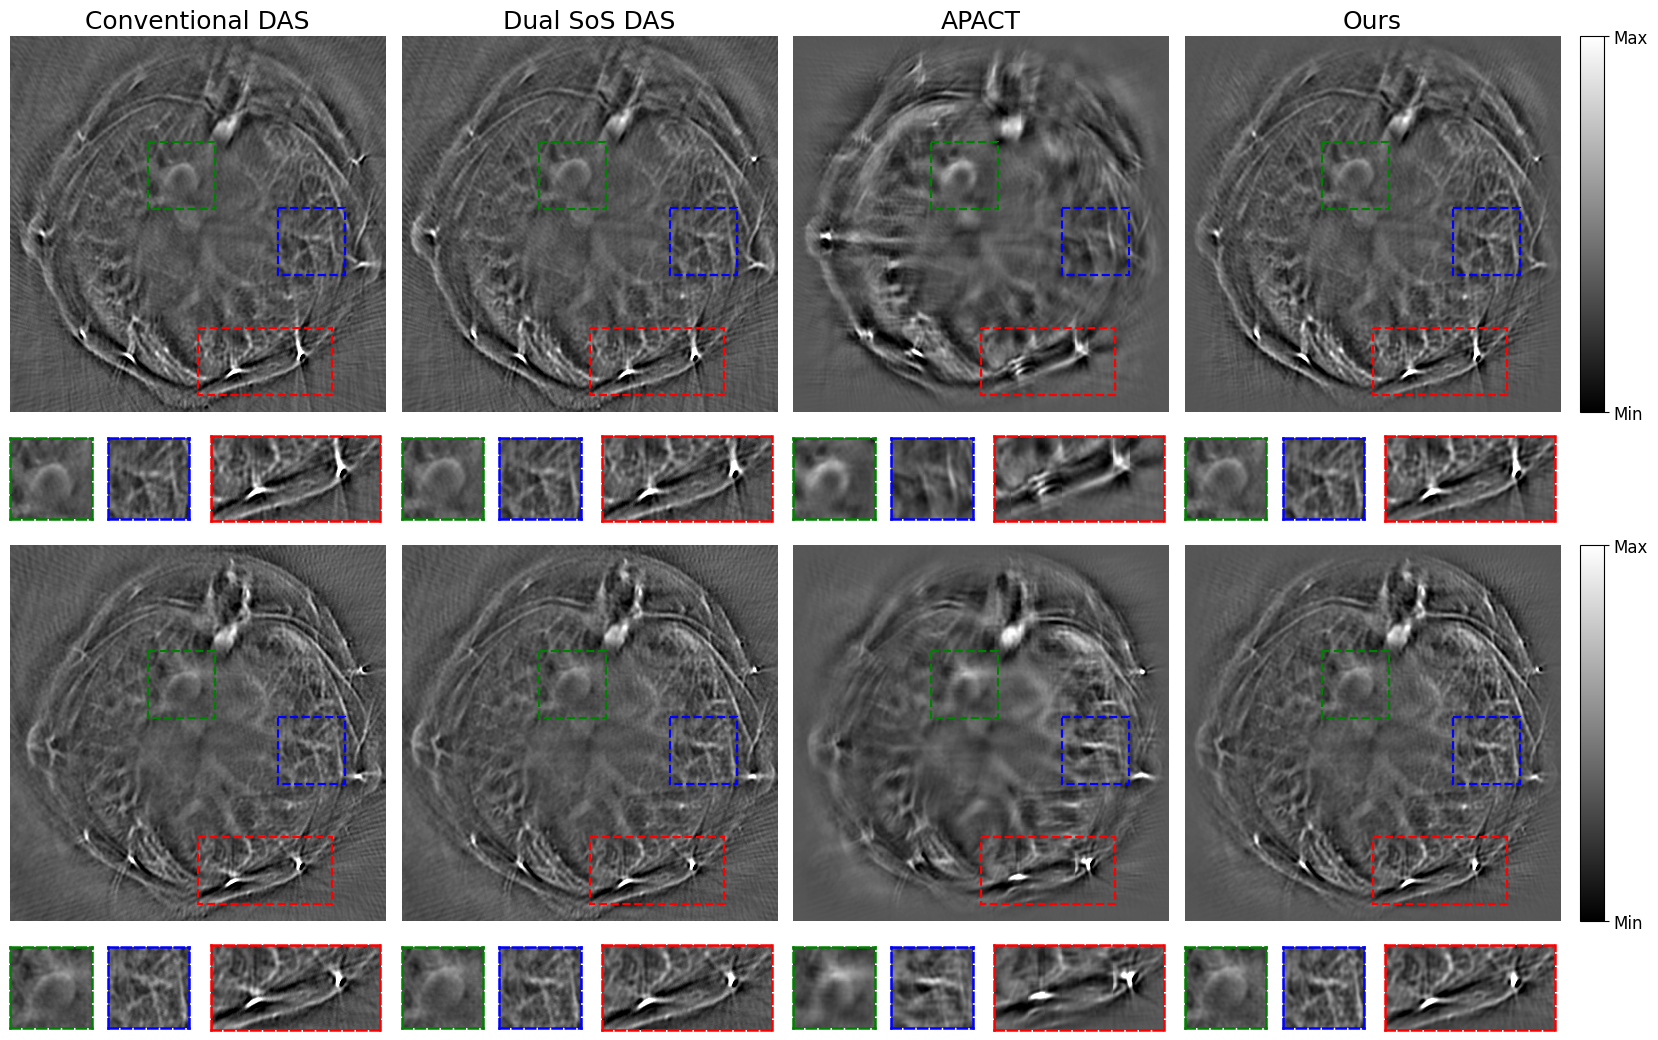

In [21]:
patches = [(157, 205, 100, 100, 'green'), (255, 400, 100, 100,'blue'), (435, 280, 100, 200, 'red')]

fig = plt.figure(figsize=(20, 13))
gs = gridspec.GridSpec(10, 16)
norm = matplotlib.colors.Normalize(vmax=7, vmin=-3.5)
methods = ['Conventional DAS', 'Dual SoS DAS', 'APACT', 'Ours']
for idx, rec_full in enumerate([rec_das1, rec_das_dual1, rec_apact1, rec_wiener1, rec_das2, rec_das_dual2, rec_apact2, rec_wiener2]):
    ax = plt.subplot(gs[5*(idx//4):5*(idx//4)+4,(idx%4)*4:(idx%4+1)*4])
    plt.imshow(rec_full, cmap='gray', norm=norm)
    if idx < 4:
        plt.title(methods[idx], fontsize=18)
    plt.axis('off')
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[5*(idx//4)+4:5*(idx//4+1),(idx%4)*4+k:(idx%4)*4+k+1+(k==2)])
        plt.imshow(rec_full[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(1.8)
            ax2.spines[loc].set_linestyle('--')
    if idx % 4 == 3:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.set_ticks(ticks=[-3.5, 7], labels=['Min', 'Max'], fontsize=12)

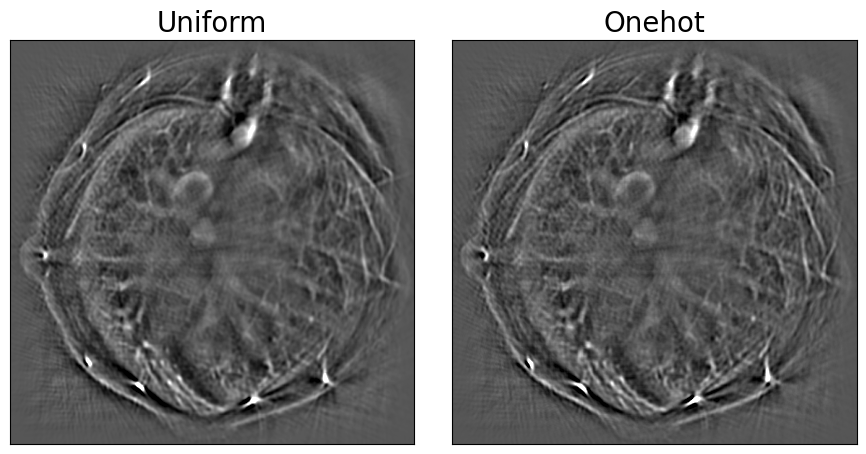

In [21]:
fig = plt.figure(figsize=(9, 4.5))
for idx, (rec_full, attention) in enumerate(zip([rec_wiener1, rec_wiener_onehot1], ['Uniform', 'Onehot'])):
        ax = plt.subplot(1,2,idx+1)
        plt.imshow(rec_full, cmap='gray', norm=norm)
        plt.title(attention, fontsize=20)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()